#  Wave Net


- `학습 내용`
    - Audio data에 대해 이해한다.
    - 머신러닝 방법으로 접근하여 문제를 해결해 본다.
    - 딥러닝 네트워크를 이용해 문제를 해결한다.
    - waveNet, yamNet 등 딥러닝 알고리즘을 적용한다.


In [41]:
import os
import tqdm
import shutil
import zipfile
import kaggle

import numpy as np
import pandas as pd

import seaborn as sns
from termcolor import colored
import set_matplotlib_hangul
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense
import tensorflow_addons as tfa
from keras.models import Sequential

from pycaret.classification import *
from xgboost import XGBRFClassifier

from sklearn import preprocessing
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# 준비

## 데이터셋 - Kaggle GTZAN Dataset 
---

https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification



* api 파일을 받아옴 (.json)
* user 의 .kaggle 폴더에 넣음

### 데이터셋 다운로드

In [61]:
# ! kaggle datasets download andradaolteanu/gtzan-dataset-music-genre-classification -

### 데이터 폴더로 이동

In [62]:
# shutil.move("gtzan-dataset-music-genre-classification.zip", "D:/Dataset/dataset/Kaggle/")

### 압축해제

In [63]:
# with zipfile.ZipFile("D:/Dataset/dataset/Kaggle/gtzan-dataset-music-genre-classification.zip","r") as zip_ref:
#     zip_ref.extractall("D:/Dataset/dataset/Kaggle/gtzan-dataset-music-genre-classification")

### 압축파일 제거

In [64]:
# if os.path.isfile("D:/Dataset/dataset/Kaggle/gtzan-dataset-music-genre-classification.zip"):
#     os.remove("D:/Dataset/dataset/Kaggle/gtzan-dataset-music-genre-classification.zip")
#     print("File has been deleted")
# else:
#     print("File does not exist")

## **| EDA**

In [24]:
file_path = "D:Dataset/dataset/Kaggle/gtzan-dataset-music-genre-classification/Data/"
df = pd.read_csv(file_path+"features_30_sec.csv")
display(df)

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,rock.00095.wav,661794,0.352063,0.080487,0.079486,0.000345,2008.149458,282174.689224,2106.541053,88609.749506,...,45.050526,-13.289984,41.754955,2.484145,36.778877,-6.713265,54.866825,-1.193787,49.950665,rock
996,rock.00096.wav,661794,0.398687,0.075086,0.076458,0.000588,2006.843354,182114.709510,2068.942009,82426.016726,...,33.851742,-10.848309,39.395096,1.881229,32.010040,-7.461491,39.196327,-2.795338,31.773624,rock
997,rock.00097.wav,661794,0.432142,0.075268,0.081651,0.000322,2077.526598,231657.968040,1927.293153,74717.124394,...,33.597008,-12.845291,36.367264,3.440978,36.001110,-12.588070,42.502201,-2.106337,29.865515,rock
998,rock.00098.wav,661794,0.362485,0.091506,0.083860,0.001211,1398.699344,240318.731073,1818.450280,109090.207161,...,46.324894,-4.416050,43.583942,1.556207,34.331261,-5.041897,47.227180,-3.590644,41.299088,rock


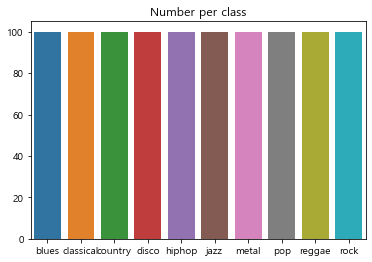

In [4]:
# 예측해야할 클래스
class_count = df["label"].value_counts()
plt.title("Number per class")
sns.barplot(x=class_count.index, y=class_count.values);

(array([305., 651.,   7.,   6.,   4.,  10.,   5.,   2.,   0.,  10.]),
 array([660000. , 661580.8, 663161.6, 664742.4, 666323.2, 667904. ,
        669484.8, 671065.6, 672646.4, 674227.2, 675808. ]),
 <BarContainer object of 10 artists>)

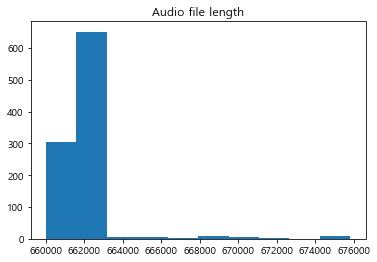

In [5]:
# 음성파일의 길이
plt.title("Audio file length")
plt.hist(df["length"])

특성 개수 57


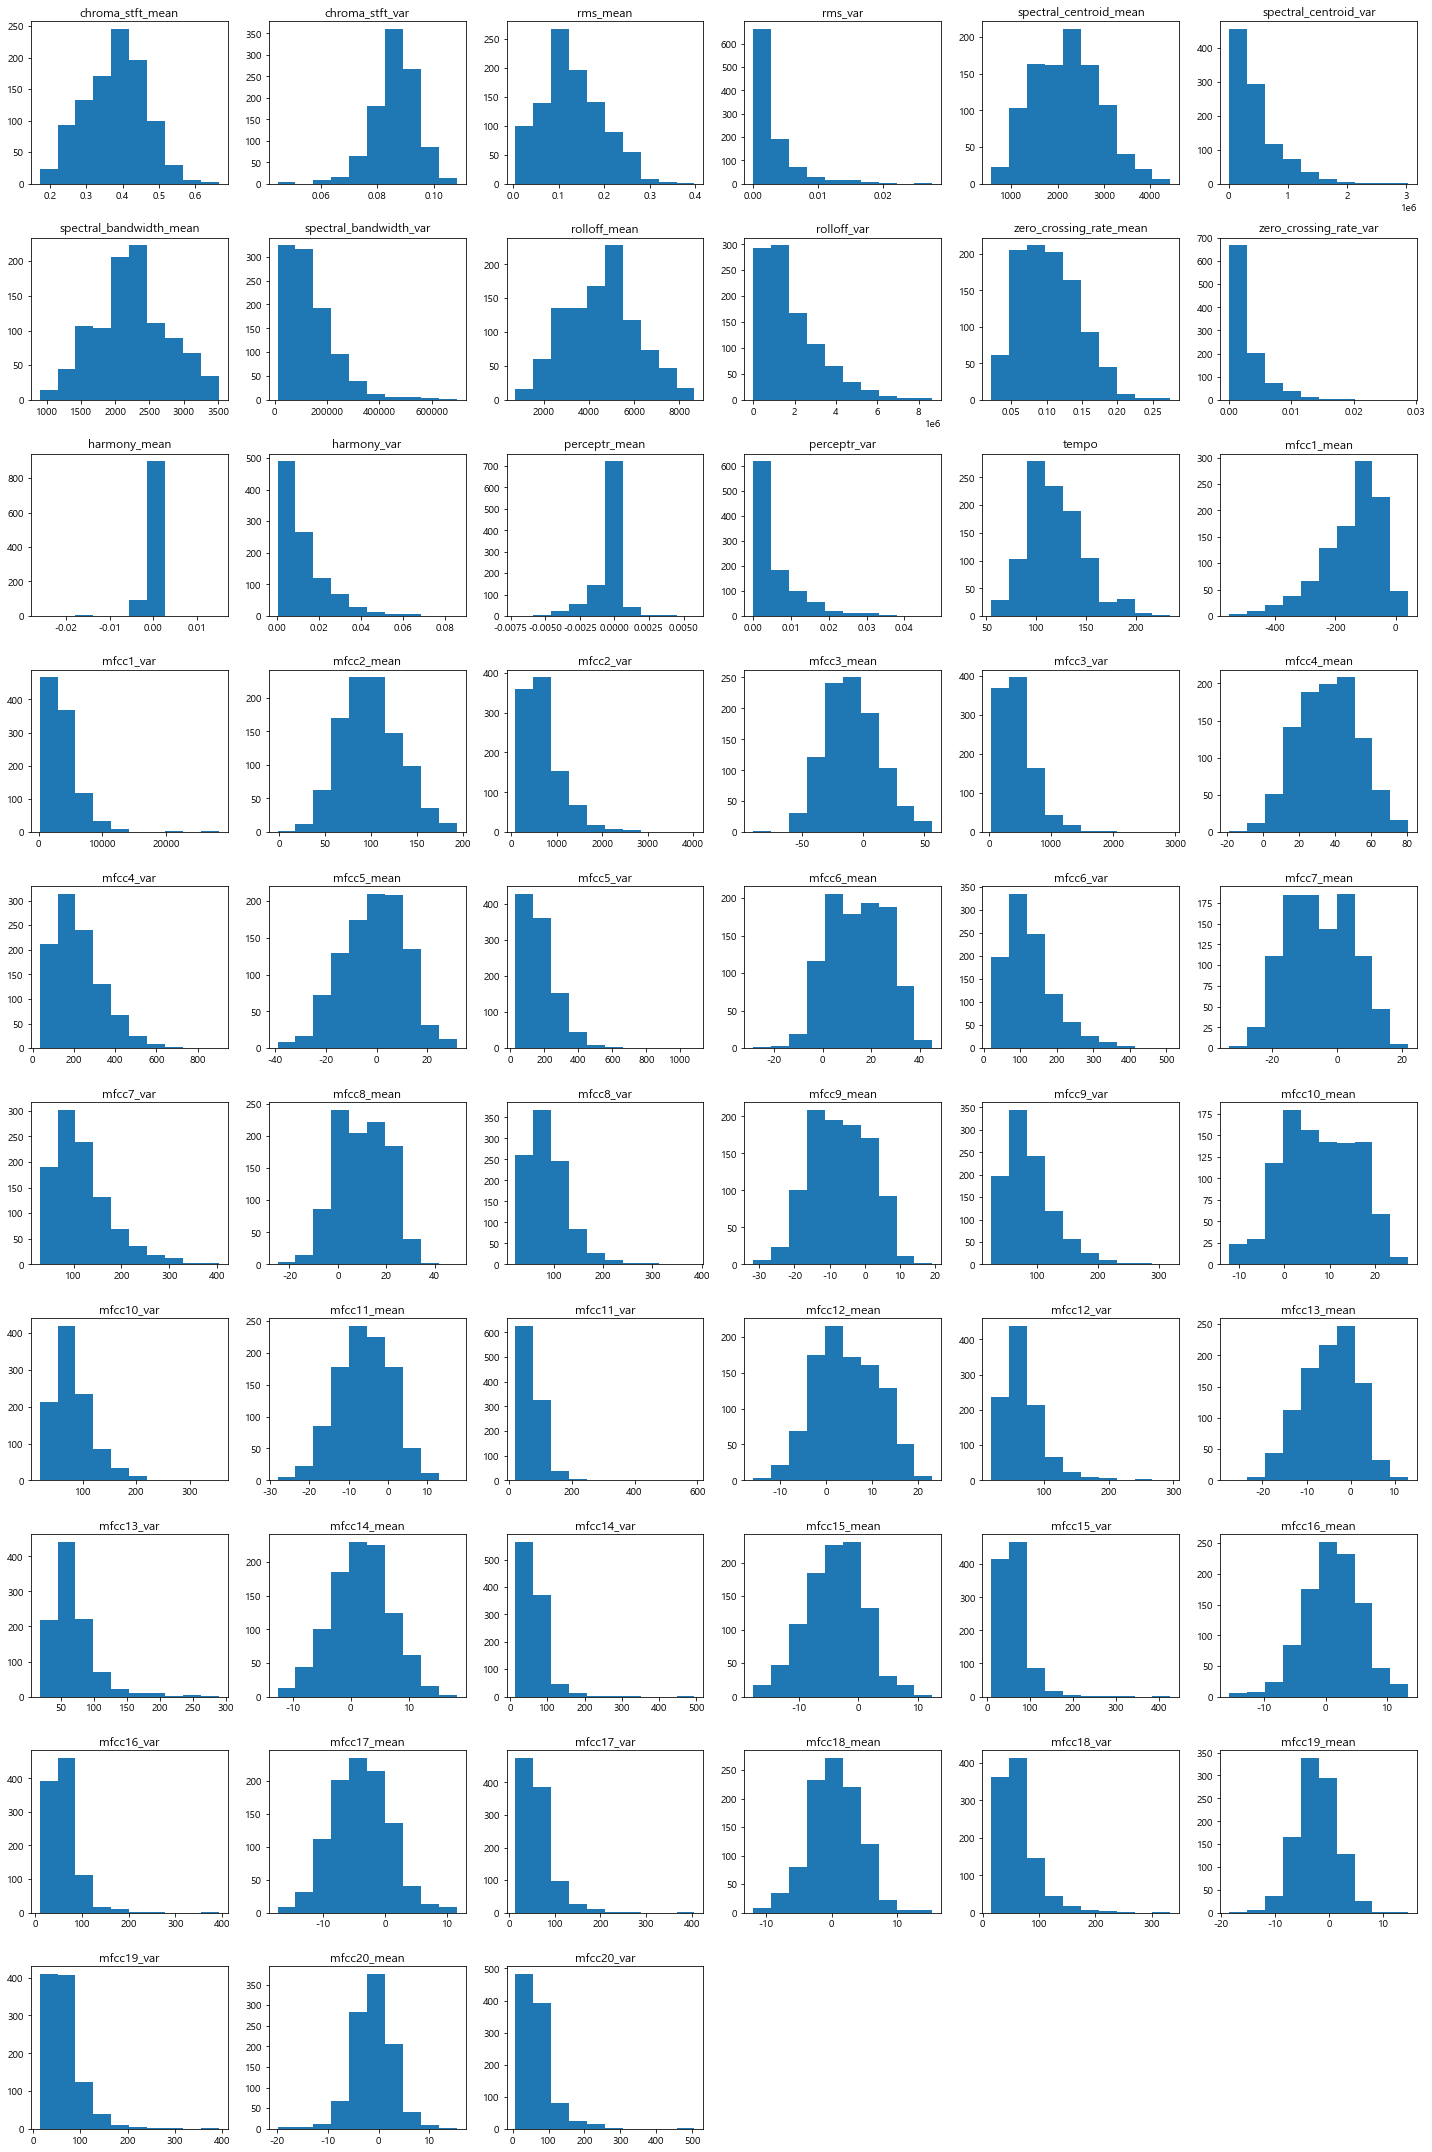

In [16]:
# 특성 분포
print("특성 개수", len(df.columns[2:-1]))
plt.figure(figsize=(20,30))
for i, col in enumerate(df.columns[2:-1]):
    plt.subplot(10,6, i+1)
    plt.title(col)
    plt.hist(df[col])
    plt.tight_layout()

# 학습

## 파라미터 추가 전

### **| 학습 - XGBoost**

#### **| 전처리**


In [25]:
le = preprocessing.LabelEncoder()
df["le_label"] = le.fit_transform(df["label"])
print(le.classes_)
display(df)

['blues' 'classical' 'country' 'disco' 'hiphop' 'jazz' 'metal' 'pop'
 'reggae' 'rock']


,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label,le_label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues,0
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues,0
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues,0
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues,0
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,rock.00095.wav,661794,0.352063,0.080487,0.079486,0.000345,2008.149458,282174.689224,2106.541053,88609.749506,...,-13.289984,41.754955,2.484145,36.778877,-6.713265,54.866825,-1.193787,49.950665,rock,9
996,rock.00096.wav,661794,0.398687,0.075086,0.076458,0.000588,2006.843354,182114.709510,2068.942009,82426.016726,...,-10.848309,39.395096,1.881229,32.010040,-7.461491,39.196327,-2.795338,31.773624,rock,9
997,rock.00097.wav,661794,0.432142,0.075268,0.081651,0.000322,2077.526598,231657.968040,1927.293153,74717.124394,...,-12.845291,36.367264,3.440978,36.001110,-12.588070,42.502201,-2.106337,29.865515,rock,9
998,rock.00098.wav,661794,0.362485,0.091506,0.083860,0.001211,1398.699344,240318.731073,1818.450280,109090.207161,...,-4.416050,43.583942,1.556207,34.331261,-5.041897,47.227180,-3.590644,41.299088,rock,9


In [26]:
x = df.drop(columns=["filename", "length", "label", "le_label"])
y = df["le_label"]
x.shape, y.shape

((1000, 57), (1000,))

In [27]:
from sklearn.model_selection import train_test_split as tts
x_train, x_test, y_train, y_test = tts(x, y, test_size=0.1, stratify=y, random_state=0)
print("x_train.shape\t: ", x_train.shape)
print("x_test.shape\t: ", x_test.shape)
print("y_train.shape\t: ", y_train.shape)
print("y_test.shape\t: ", y_test.shape)

x_train.shape	:  (900, 57)
x_test.shape	:  (100, 57)
y_train.shape	:  (900,)
y_test.shape	:  (100,)


In [28]:
# x 정규화
sc = preprocessing.StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)
print("x_train.shape\t: ", x_train.shape)
print("x_test.shape\t: ", x_test.shape)

x_train.shape	:  (900, 57)
x_test.shape	:  (100, 57)


#### 학습

In [29]:
xgb = XGBRFClassifier(n_estimators=1000)
xgb.fit(x_train, y_train)

XGBRFClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                colsample_bylevel=1, colsample_bytree=1,
                early_stopping_rounds=None, enable_categorical=False,
                eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
                importance_type=None, interaction_constraints='', max_bin=256,
                max_cat_to_onehot=4, max_delta_step=0, max_depth=6,
                max_leaves=0, min_child_weight=1, missing=nan,
                monotone_constraints='()', n_estimators=1000, n_jobs=0,
                num_parallel_tree=1000, objective='multi:softprob',
                predictor='auto', random_state=0, reg_alpha=0,
                sampling_method='uniform', scale_pos_weight=None, ...)

#### 결과

Test Acc	: 0.74 


Classfication_report :
               precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       1.00      0.90      0.95        10
           2       0.67      1.00      0.80        10
           3       0.70      0.70      0.70        10
           4       0.50      0.40      0.44        10
           5       0.89      0.80      0.84        10
           6       0.69      0.90      0.78        10
           7       0.88      0.70      0.78        10
           8       0.54      0.70      0.61        10
           9       1.00      0.50      0.67        10

    accuracy                           0.74       100
   macro avg       0.77      0.74      0.74       100
weighted avg       0.77      0.74      0.74       100



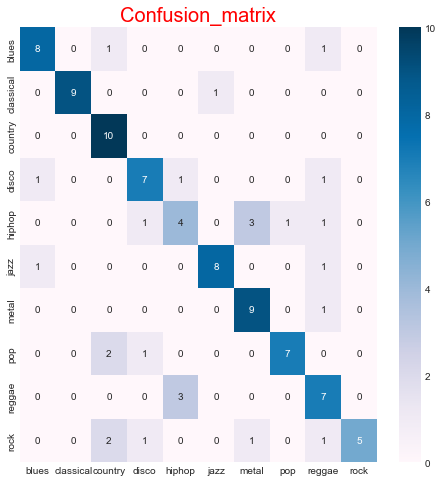

In [30]:
y_pred = xgb.predict(x_test)
print(colored("Test Acc\t:","red"),accuracy_score(y_test, y_pred),"\n\n")
print(colored("Classfication_report :\n", "red"), classification_report(y_test, y_pred))
plt.figure(figsize=(8,8))
plt.title("Confusion_matrix", fontsize=20, color="red")
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap="PuBu", xticklabels=le.classes_, yticklabels=le.classes_);

### **| 학습 - DNN**

In [43]:
tqdm_callback = tfa.callbacks.TQDMProgressBar(show_epoch_progress=False)

#### 모델

In [44]:
model = Sequential()
model.add(Dense(120, input_dim=57, activation='elu', kernel_initializer=tf.keras.initializers.HeNormal()))
model.add(Dense(200, activation='elu', kernel_initializer=tf.keras.initializers.HeNormal()))
model.add(Dense(100, activation='elu', kernel_initializer=tf.keras.initializers.HeNormal()))
model.add(Dense(30, activation='elu', kernel_initializer=tf.keras.initializers.HeNormal()))
model.add(Dense(10, activation='softmax', kernel_initializer=tf.keras.initializers.HeNormal()))
opt = tf.keras.optimizers.Adam()
model.compile(optimizer=opt, loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["acc"])
ckp = tf.keras.callbacks.ModelCheckpoint("model/ckp.h5", save_best_only=True, monitor="val_acc")
lr = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, monitor="val_loss", patience=5, cooldown=3)
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 120)               6960      
                                                                 
 dense_19 (Dense)            (None, 200)               24200     
                                                                 
 dense_20 (Dense)            (None, 100)               20100     
                                                                 
 dense_21 (Dense)            (None, 30)                3030      
                                                                 
 dense_22 (Dense)            (None, 10)                310       
                                                                 
Total params: 54,600
Trainable params: 54,600
Non-trainable params: 0
_________________________________________________________________


#### 학습

In [46]:
epochs_hist = model.fit(x_train, y_train, epochs=500, batch_size=50, validation_split=0.1, callbacks=[ckp, lr,tqdm_callback], verbose=0)

Training:   0%|                                                                               0/500 ETA: ?s,  …

#### 결과

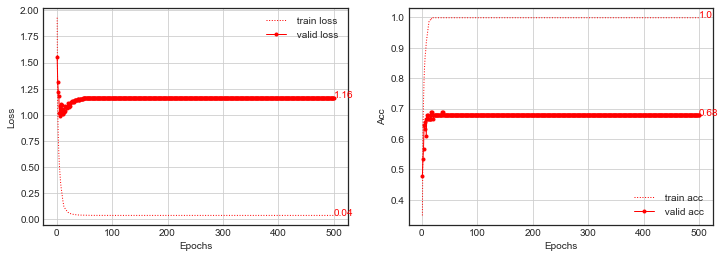

In [47]:
from Myfunc import show_lcurve
show_lcurve([epochs_hist], [""], x_itv=100)

4/4 [==============================] - 0s 1ms/step
Test Acc	: 0.75 




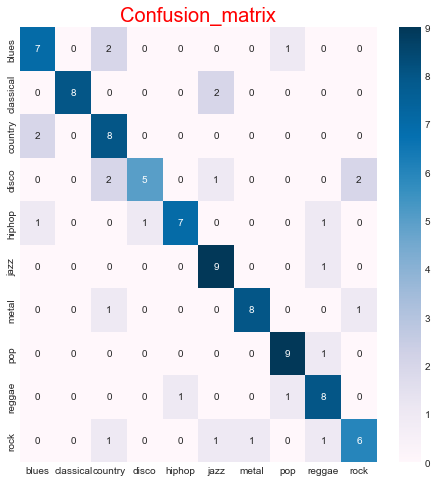

In [48]:

model = tf.keras.models.load_model("model/ckp.h5")
y_pred = model.predict(x_test)
y_pred = tf.argmax(y_pred, axis=1)
print(colored("Test Acc\t:","red"),accuracy_score(y_test, y_pred),"\n\n")
plt.figure(figsize=(8,8))
plt.title("Confusion_matrix", fontsize=20, color="red")
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap="PuBu", xticklabels=le.classes_, yticklabels=le.classes_);

## 파라미터 추가 후
---

### 파라미터 추가

0it [00:00, ?it/s]

chroma_cens_mean 	: 0.27226317
chroma_cens_var 	: 0.009206081
spectral_contrast_mean 	: 20.523289104984585
spectral_contrast_var 	: 76.80119100984597
spectral_flatness_mean 	: 0.0044955737
spectral_flatness_var 	: 3.0314568e-05
tonnetz_mean 	: 0.006427515020328565
tonnetz_var 	: 0.004309638900279141


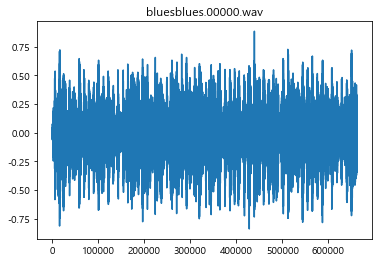

1it [00:00,  1.03it/s]

chroma_cens_mean 	: 0.26107782
chroma_cens_var 	: 0.015171697
spectral_contrast_mean 	: 20.672485756359524
spectral_contrast_var 	: 67.8618450598419
spectral_flatness_mean 	: 0.0022980976
spectral_flatness_var 	: 2.3548295e-05
tonnetz_mean 	: 0.029378210231407072
tonnetz_var 	: 0.004747541854429701


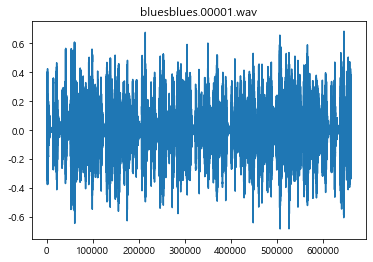

1000it [13:51,  1.20it/s]


In [49]:
# new_var = defaultdict(list)

# for idx, row in tqdm(df.iterrows()):
    
#     dir_path = "D:Dataset/dataset/Kaggle/gtzan-dataset-music-genre-classification/Data/genres_original/"+row["label"]
#     file_path = dir_path +"/"+ row["filename"]
    
#     if row["filename"] != "jazz.00054.wav": 
#         y, sr = librosa.load(file_path)
#         chroma_cens = librosa.feature.chroma_cens(y=y, sr=sr)
#         spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
#         spectral_flatness = librosa.feature.spectral_flatness(y=y)
#         tonnetz = librosa.feature.tonnetz(y=y, sr=sr)

#         chroma_cens_mean = np.mean(chroma_cens)
#         chroma_cens_var = np.var(chroma_cens)
#         spectral_contrast_mean = np.mean(spectral_contrast)
#         spectral_contrast_var = np.var(spectral_contrast)
#         spectral_flatness_mean = np.mean(spectral_flatness)
#         spectral_flatness_var = np.var(spectral_flatness)
#         tonnetz_mean = np.mean(tonnetz)
#         tonnetz_var = np.var(tonnetz)

#         new_var["chroma_cens_mean"].append(chroma_cens_mean)
#         new_var["chroma_cens_var"].append(chroma_cens_var)
#         new_var["spectral_contrast_mean"].append(spectral_contrast_mean)
#         new_var["spectral_contrast_var"].append(spectral_contrast_var)
#         new_var["spectral_flatness_mean"].append(spectral_flatness_mean)
#         new_var["spectral_flatness_var"].append(spectral_flatness_var)
#         new_var["tonnetz_mean"].append(tonnetz_mean)
#         new_var["tonnetz_var"].append(tonnetz_var)
#     else:
#         new_var["chroma_cens_mean"].append(0)
#         new_var["chroma_cens_var"].append(0)
#         new_var["spectral_contrast_mean"].append(0)
#         new_var["spectral_contrast_var"].append(0)
#         new_var["spectral_flatness_mean"].append(0)
#         new_var["spectral_flatness_var"].append(0)
#         new_var["tonnetz_mean"].append(0)
#         new_var["tonnetz_var"].append(0)
    
#     if idx < 2:
#         print("chroma_cens_mean \t:", chroma_cens_mean)
#         print("chroma_cens_var \t:", chroma_cens_var)
#         print("spectral_contrast_mean \t:", spectral_contrast_mean)
#         print("spectral_contrast_var \t:", spectral_contrast_var)
#         print("spectral_flatness_mean \t:", spectral_flatness_mean)
#         print("spectral_flatness_var \t:", spectral_flatness_var)
#         print("tonnetz_mean \t:", tonnetz_mean)
#         print("tonnetz_var \t:", tonnetz_var)

#         plt.title(row["label"]+row["filename"])
#         plt.plot(y)
#         plt.show()

# df = pd.read_csv(file_path+"features_30_sec.csv")
# df["chroma_cens_mean"] = new_var["chroma_cens_mean"]
# df["chroma_cens_var"] = new_var["chroma_cens_var"]
# df["spectral_contrast_mean"] = new_var["spectral_contrast_mean"]
# df["spectral_contrast_var"] = new_var["spectral_contrast_var"]
# df["spectral_flatness_var"] = new_var["spectral_flatness_var"]
# df["spectral_flatness_mean"] = new_var["spectral_flatness_mean"]
# df["tonnetz_mean"] = new_var["tonnetz_mean"]
# df["tonnetz_var"] = new_var["tonnetz_var"]
# df.to_csv(file_path+"feature_30_sec_new.csv", index=False)

In [51]:
df = pd.read_csv(file_path+"feature_30_sec_new.csv")
df

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc20_var,label,chroma_cens_mean,chroma_cens_var,spectral_contrast_mean,spectral_contrast_var,spectral_flatness_var,spectral_flatness_mean,tonnetz_mean,tonnetz_var
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,46.936035,blues,0.272263,0.009206,20.523289,76.801191,0.000030,0.004496,0.006428,0.004310
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,45.786282,blues,0.261078,0.015172,20.672486,67.861845,0.000024,0.002298,0.029378,0.004748
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,30.573025,blues,0.262717,0.014313,22.191292,76.122598,0.000011,0.002635,0.024224,0.010467
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,31.949339,blues,0.226096,0.032214,21.423621,63.386763,0.000003,0.000955,0.026662,0.017941
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,55.195160,blues,0.259727,0.015875,21.459618,63.033892,0.000019,0.003240,-0.020945,0.010100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,rock.00095.wav,661794,0.352063,0.080487,0.079486,0.000345,2008.149458,282174.689224,2106.541053,88609.749506,...,49.950665,rock,0.226536,0.032015,22.977342,69.887654,0.000060,0.006556,0.018374,0.027887
996,rock.00096.wav,661794,0.398687,0.075086,0.076458,0.000588,2006.843354,182114.709510,2068.942009,82426.016726,...,31.773624,rock,0.234609,0.028292,22.665250,73.647724,0.000034,0.006473,-0.001153,0.027370
997,rock.00097.wav,661794,0.432142,0.075268,0.081651,0.000322,2077.526598,231657.968040,1927.293153,74717.124394,...,29.865515,rock,0.260923,0.015253,22.309244,70.794790,0.000087,0.007556,0.017200,0.010772
998,rock.00098.wav,661794,0.362485,0.091506,0.083860,0.001211,1398.699344,240318.731073,1818.450280,109090.207161,...,41.299088,rock,0.240758,0.025369,22.491635,55.227212,0.000008,0.001716,0.056722,0.014235


### | 학습 - XGBoost

In [21]:
le = preprocessing.LabelEncoder()
df["le_label"] = le.fit_transform(df["label"])
x = df.drop(columns=["filename", "length", "label", "le_label"])
y = df["le_label"]
x_train, x_test, y_train, y_test = tts(x, y, test_size=0.1, stratify=y, random_state=0)

print("x_train.shape\t: ", x_train.shape)
print("x_test.shape\t: ", x_test.shape)
print("y_train.shape\t: ", y_train.shape)
print("y_test.shape\t: ", y_test.shape)

x_train.shape	:  (900, 65)
x_test.shape	:  (100, 65)
y_train.shape	:  (900,)
y_test.shape	:  (100,)


In [22]:
from xgboost import XGBRFClassifier
xgb = XGBRFClassifier(n_estimators=1000)
xgb.fit(x_train, y_train)

XGBRFClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                colsample_bylevel=1, colsample_bynode=0.8, colsample_bytree=1,
                early_stopping_rounds=None, enable_categorical=False,
                eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
                importance_type=None, interaction_constraints='',
                learning_rate=1.0, max_bin=256, max_cat_to_onehot=4,
                max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
                missing=nan, monotone_constraints='()', n_estimators=1000,
                n_jobs=0, num_parallel_tree=1000, objective='multi:softprob',
                predictor='auto', random_state=0, reg_alpha=0, ...)

Test Acc	: 0.76 


Classfication_report :
               precision    recall  f1-score   support

           0       0.90      0.90      0.90        10
           1       1.00      0.90      0.95        10
           2       0.62      0.80      0.70        10
           3       0.70      0.70      0.70        10
           4       0.56      0.50      0.53        10
           5       0.90      0.90      0.90        10
           6       0.75      0.90      0.82        10
           7       0.80      0.80      0.80        10
           8       0.58      0.70      0.64        10
           9       1.00      0.50      0.67        10

    accuracy                           0.76       100
   macro avg       0.78      0.76      0.76       100
weighted avg       0.78      0.76      0.76       100



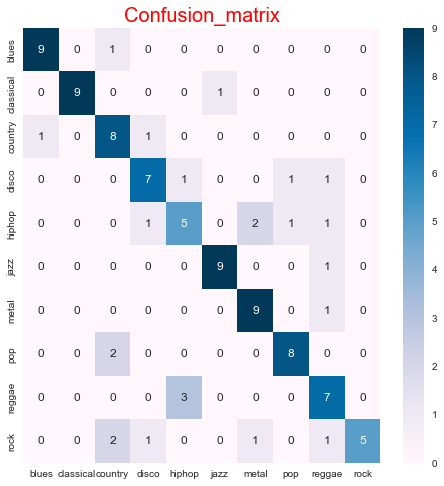

In [23]:
y_pred = xgb.predict(x_test)
print(colored("Test Acc\t:","red"),accuracy_score(y_test, y_pred),"\n\n")
print(colored("Classfication_report :\n", "red"), classification_report(y_test, y_pred))
plt.figure(figsize=(8,8))
plt.title("Confusion_matrix", fontsize=20, color="red")
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap="PuBu", xticklabels=le.classes_, yticklabels=le.classes_);

### | 학습 - pycaret

In [12]:
le = preprocessing.LabelEncoder()
df["le_label"] = le.fit_transform(df["label"])

df = df.drop(columns=["filename", "length", "label"])
df_train, df_test = tts(df, test_size=0.1, stratify=df["le_label"], random_state=0)

In [14]:
s = setup(df_train, target = 'le_label', train_size=0.9)

,Description,Value
0,session_id,4722
1,Target,le_label
2,Target Type,Multiclass
3,Label Encoded,None
4,Original Data,"(900, 66)"
5,Missing Values,False
6,Numeric Features,65
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [15]:
best = compare_models(n_select=3, sort="Accuracy")

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.7593,0.9683,0.7601,0.7720,0.7552,0.7325,0.7347,30.2540
lightgbm,Light Gradient Boosting Machine,0.7531,0.9566,0.7548,0.7662,0.7488,0.7256,0.7279,0.4340
et,Extra Trees Classifier,0.7383,0.9575,0.7384,0.7519,0.7331,0.7091,0.7118,0.0330
xgboost,Extreme Gradient Boosting,0.7173,0.9544,0.7184,0.7321,0.7149,0.6858,0.6880,0.3320
rf,Random Forest Classifier,0.7136,0.9567,0.7140,0.7311,0.7094,0.6816,0.6846,0.0490
lda,Linear Discriminant Analysis,0.7136,0.9504,0.7130,0.7412,0.7129,0.6815,0.6848,0.2120
gbc,Gradient Boosting Classifier,0.7037,0.9495,0.7049,0.7262,0.7052,0.6707,0.6731,1.4590
ridge,Ridge Classifier,0.6235,0.0000,0.6239,0.6404,0.5994,0.5814,0.5871,0.0030
dt,Decision Tree Classifier,0.5136,0.7298,0.5151,0.5253,0.5099,0.4595,0.4614,0.2080
qda,Quadratic Discriminant Analysis,0.4667,0.8086,0.4633,0.5672,0.4493,0.4062,0.4229,0.0050


In [16]:
blender = blend_models(estimator_list=best)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8272,0.9809,0.8260,0.8304,0.8219,0.8078,0.8094
1,0.7160,0.9622,0.7194,0.7500,0.7142,0.6847,0.6880
2,0.7407,0.9666,0.7403,0.7605,0.7430,0.7118,0.7133
3,0.7284,0.9604,0.7333,0.7284,0.7209,0.6984,0.7002
4,0.7901,0.9744,0.7895,0.7948,0.7859,0.7667,0.7683
5,0.8272,0.9766,0.8278,0.8332,0.8193,0.8078,0.8102
6,0.8272,0.9766,0.8302,0.8415,0.8228,0.8079,0.8105
7,0.7901,0.9536,0.7927,0.8168,0.7960,0.7667,0.7689
8,0.7284,0.9654,0.7292,0.7347,0.7233,0.6981,0.7004


In [17]:
final = finalize_model(blender)

In [20]:
df_test_x = df_test.drop(["le_label"], axis=1)
df_test_y = df_test["le_label"]
y_pred = predict_model(final, data=df_test_x)

In [23]:
y_pred["Label"]

21     0
430    3
621    6
733    8
393    3
      ..
654    6
449    4
425    4
282    2
570    5
Name: Label, Length: 100, dtype: int32

Test Acc	: 0.83 


Classfication_report :
               precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       1.00      0.90      0.95        10
           2       0.71      1.00      0.83        10
           3       0.80      0.80      0.80        10
           4       0.80      0.80      0.80        10
           5       0.82      0.90      0.86        10
           6       0.82      0.90      0.86        10
           7       1.00      0.80      0.89        10
           8       0.58      0.70      0.64        10
           9       1.00      0.60      0.75        10

    accuracy                           0.83       100
   macro avg       0.85      0.83      0.83       100
weighted avg       0.85      0.83      0.83       100



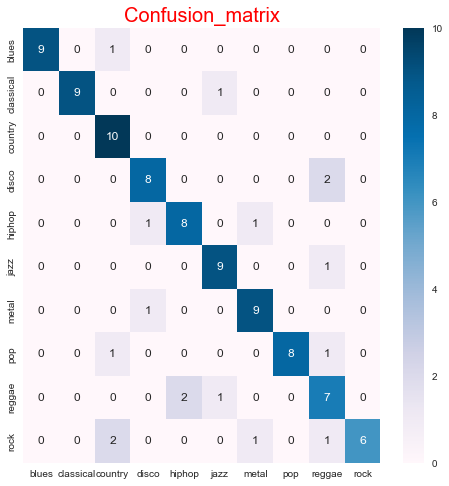

In [24]:
print(colored("Test Acc\t:","red"),accuracy_score(df_test_y, y_pred["Label"]),"\n\n")
print(colored("Classfication_report :\n", "red"), classification_report(df_test_y, y_pred["Label"]))
plt.figure(figsize=(8,8))
plt.title("Confusion_matrix", fontsize=20, color="red")
sns.heatmap(confusion_matrix(df_test_y, y_pred["Label"]), annot=True, cmap="PuBu", xticklabels=le.classes_, yticklabels=le.classes_);

### | 학습 - DNN

In [52]:
le = preprocessing.LabelEncoder()
df["le_label"] = le.fit_transform(df["label"])

x = df.drop(columns=["filename", "length", "label", "le_label"])
y = df["le_label"]

x_train, x_test, y_train, y_test = tts(x, y, test_size=0.1, stratify=df["le_label"], random_state=0)

#### 모델

In [57]:
model = Sequential()
model.add(Dense(120, input_dim=65, activation='elu', kernel_initializer=tf.keras.initializers.HeNormal()))
model.add(Dense(200, activation='elu', kernel_initializer=tf.keras.initializers.HeNormal()))
model.add(Dense(100, activation='elu', kernel_initializer=tf.keras.initializers.HeNormal()))
model.add(Dense(30, activation='elu', kernel_initializer=tf.keras.initializers.HeNormal()))
model.add(Dense(10, activation='softmax', kernel_initializer=tf.keras.initializers.HeNormal()))
opt = tf.keras.optimizers.Adam()
model.compile(optimizer=opt, loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["acc"])
ckp = tf.keras.callbacks.ModelCheckpoint("model/ckp.h5", save_best_only=True, monitor="val_acc")
lr = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, monitor="val_loss", patience=5, cooldown=3)
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_33 (Dense)            (None, 120)               7920      
                                                                 
 dense_34 (Dense)            (None, 200)               24200     
                                                                 
 dense_35 (Dense)            (None, 100)               20100     
                                                                 
 dense_36 (Dense)            (None, 30)                3030      
                                                                 
 dense_37 (Dense)            (None, 10)                310       
                                                                 
Total params: 55,560
Trainable params: 55,560
Non-trainable params: 0
_________________________________________________________________


#### 학습

In [58]:
epochs_hist = model.fit(x_train, y_train, epochs=500, batch_size=50, validation_split=0.1, callbacks=[ckp, lr,tqdm_callback], verbose=0)

Training:   0%|                                                                               0/500 ETA: ?s,  …

#### 결과

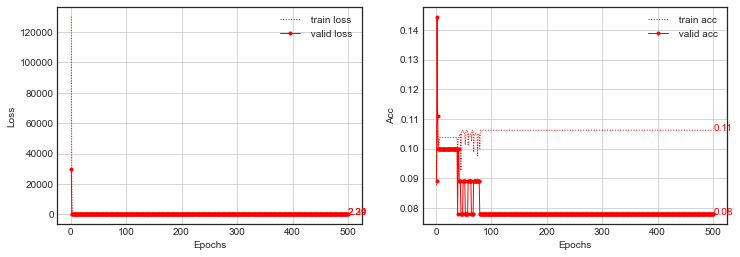

In [59]:
from Myfunc import show_lcurve
show_lcurve([epochs_hist], [""], x_itv=100)

4/4 [==============================] - 0s 2ms/step
Test Acc	: 0.14 




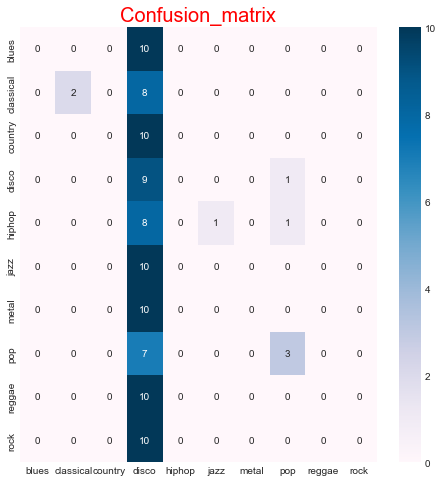

In [60]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from termcolor import colored

model = tf.keras.models.load_model("model/ckp.h5")
y_pred = model.predict(x_test)
y_pred = tf.argmax(y_pred, axis=1)
print(colored("Test Acc\t:","red"),accuracy_score(y_test, y_pred),"\n\n")
plt.figure(figsize=(8,8))
plt.title("Confusion_matrix", fontsize=20, color="red")
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap="PuBu", xticklabels=le.classes_, yticklabels=le.classes_);